# FTICR-MS Processing and Display

a simplified environment for processing 1D Bruker FTICR datasets with `SPIKE`

Run each python cell in sequence by using the ⇥Run button above (or typing *shift* Enter).

Cells are meant to be used in order, taking you to the complete analysis, but you can go back at any time.

### Initialization of the environment
the following cell should be run only once, at the beginning of the processing

In [1]:
# load all python and interactive tools
from __future__ import print_function, division
%matplotlib notebook
import os.path as op
import spike
from spike.Interactive import INTER as I
from spike.Interactive import FTICR_INTER as FI
from spike.File import BrukerMS
from IPython.display import display, HTML
display(HTML('<b>Program is Ready</b>'))


          SPIKE
    Version     : 0.99.6
    Date        : 12-04-2019
    Revision Id : 405
*** Importing  << zoom3D >> Failed ***
plugins loaded:
Bruker_NMR_FT,  Bucketing,  FTMS_calib,  Fitter,  Linear_prediction,  PALMA,  Peaks,  apmin,  bcorr,  bokeh_display,  fastclean,  gaussenh,  pg_sane,  rem_ridge,  sane,  sg,  test,  tisane,  urQRd,  wavelet, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin


### Choose the file
Use `FileChooser()` to choose a file on your disk - The optional `base` argument, starts the exploration on a given location.

Bruker files are named `fid` and are contained in a `*.d` directory.

In [2]:
FC = I.FileChooser(base='/DATA', filetype='fid')

(After the selection, the selected filename is found in the `FC.file` variable)
### Import dataset

This is simply done with the `Import_1D()` tool, which returns a `SPIKE` object.

We store it into a variable, evaluating the variable show a summary of the dataset. 

Reading file  120514_lysonatif_000001.d


<IPython.core.display.Javascript object>


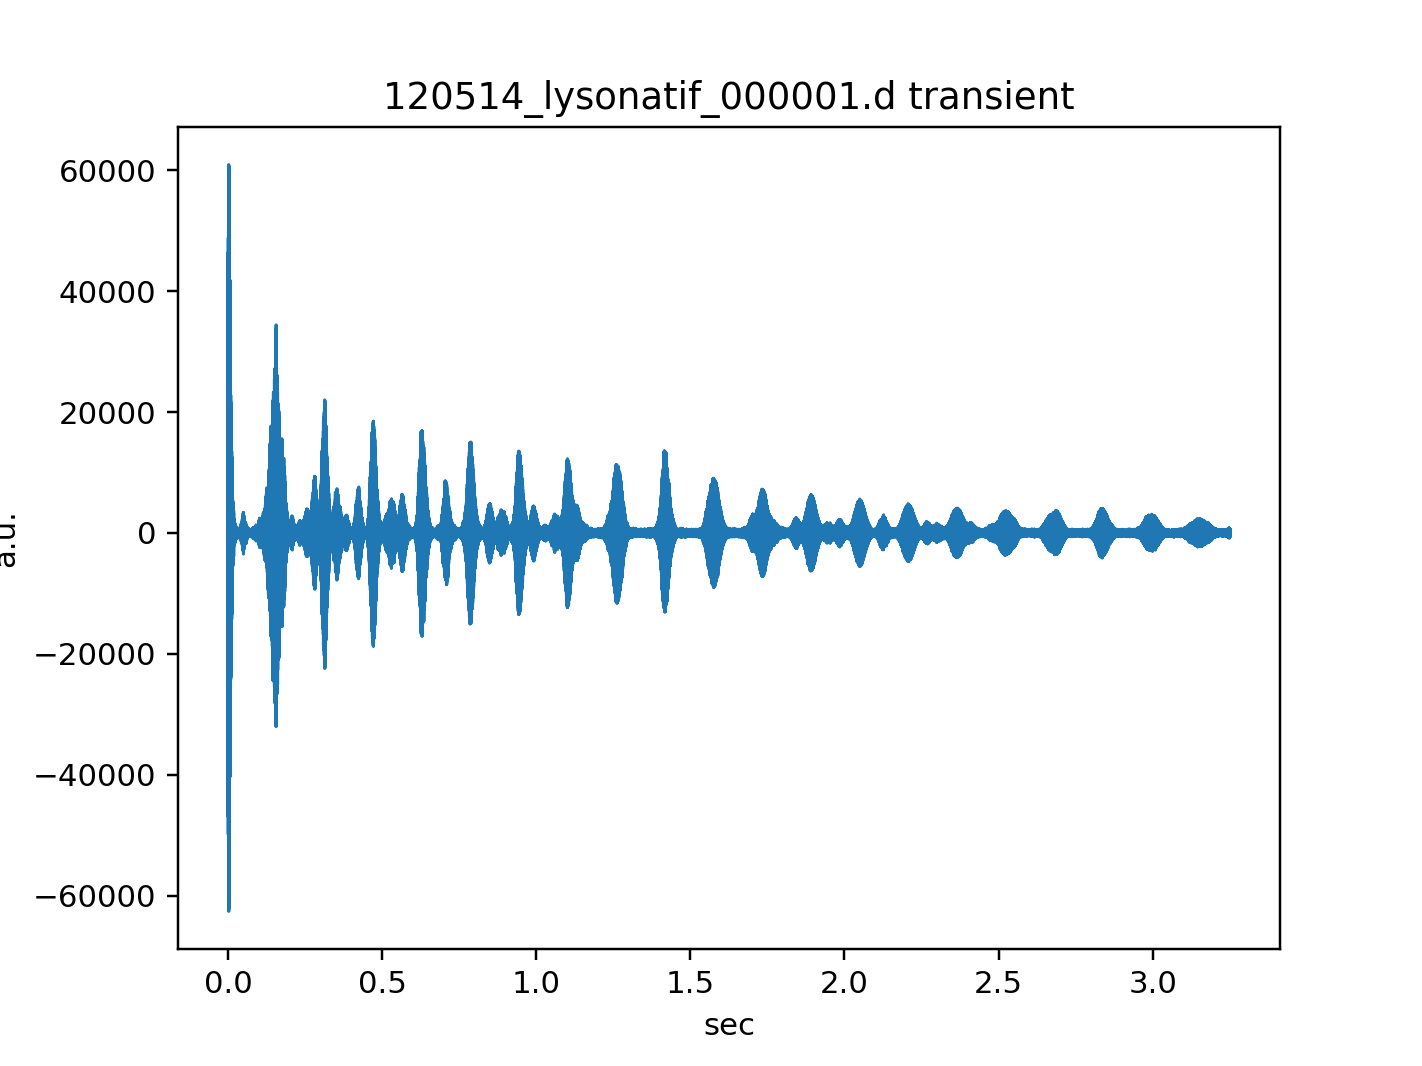

1D data-set
Axis F1 :FT-ICR report axis at 161.290323 kHz,  1048576 real points,  from physical mz =  894.712   to m/z = 2200.000  R max (M=400) = 2343561
data-set is real

In [9]:
print('Reading file ',FC.dirname)
d1 = BrukerMS.Import_1D(FC.file)
d1.filename = FC.file
d1.set_unit('sec').display(title=FC.dirname+" transient")
d1

In the current set-up, the figure can be explored *(zoom, shift, resize, etc)* with the jupyter tools displayed  below the dataset.
The figure can also be saved as a `png` graphic file.

At anytime, the figure can be frozen by clicking on the blue button on the upper right corner, just rerun the cell for changing it.

### Compute Spectrum

many processing methods are available, they can be either applied one by one, or piped by chaining them.

Here we are chaining  apodisation - zerofill - FT - modulus

then setting to `m/z` unit (`Hz` and `points` also available) - finally `display()` is used to display the dataset.


<IPython.core.display.Javascript object>


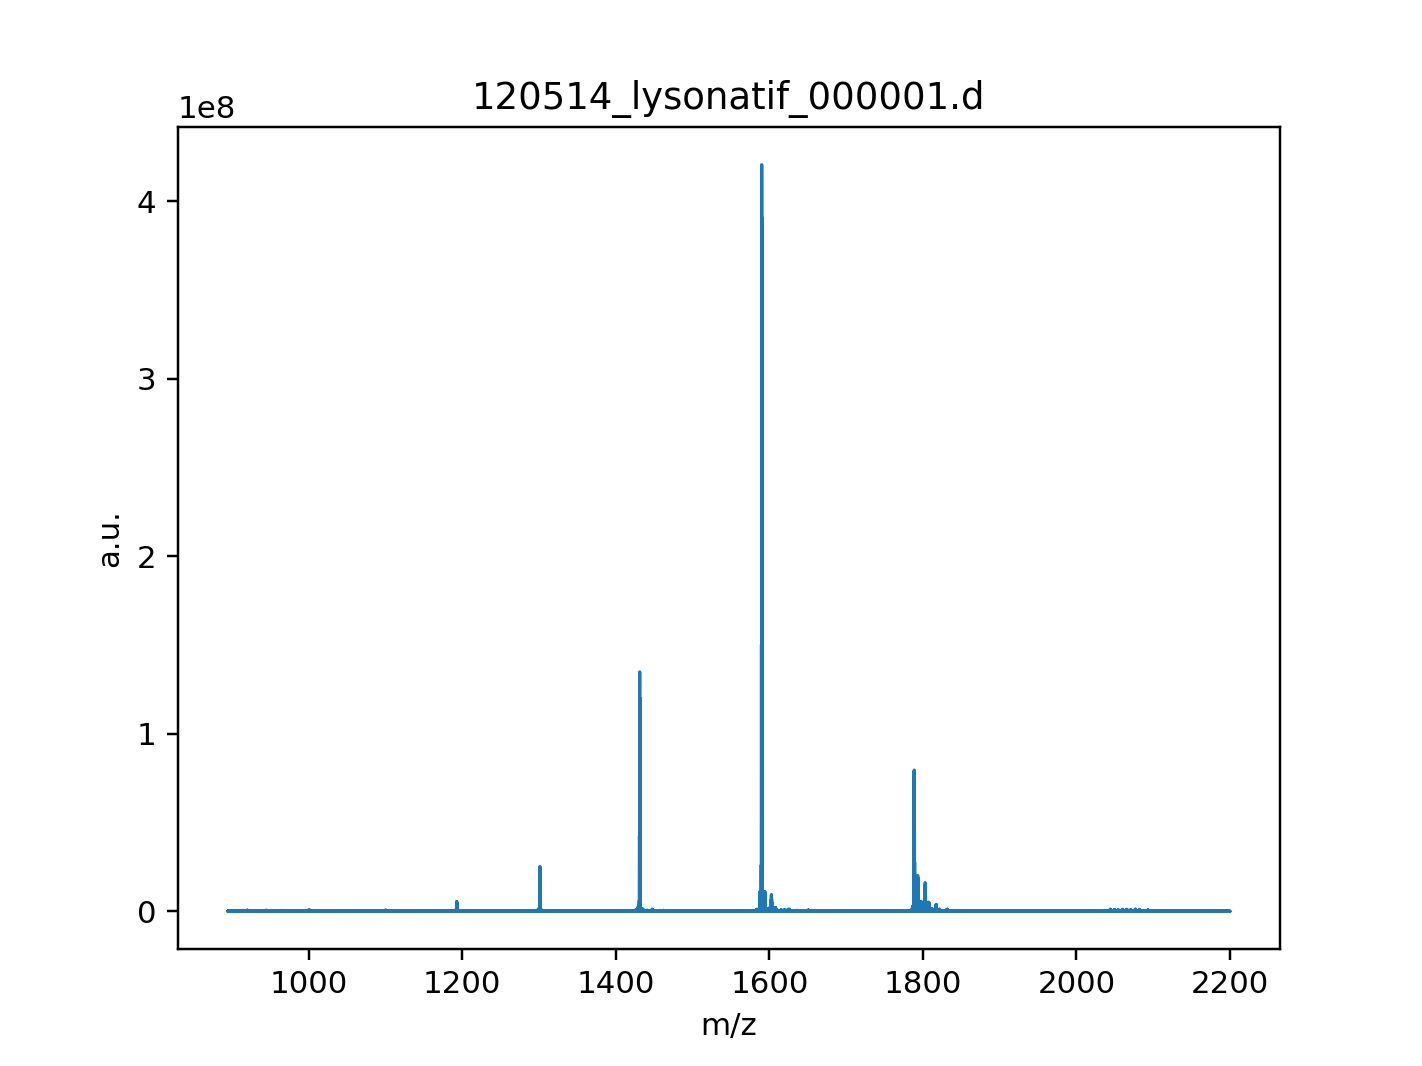

1D data-set
Axis F1 :FT-ICR report axis at 161.290323 kHz,  2097152 real points,  from physical mz =  894.712   to m/z = 2200.000  R max (M=400) = 4687124
data-set is real

In [10]:
D1 = d1.copy() # copy the imported data-set to another object for processing
D1.kaiser(4).zf(4).rfft().modulus() # kaiser(4) is an apodisation well adapted to FTICR, slightly more resolution than hamming(
D1.set_unit('m/z').display(title=FC.dirname)  # set to ppm unit - and display

### Peak Detection
The following macro is used to perform an interactive peak picking, and output the result
Use the cursor to choose the sensitivity of the picker.

In [11]:
from importlib import reload
reload(FI)
pkname = op.join(op.dirname(FC.file),"peak_list.txt")
FI.MSPeaker(D1, pkname);

Peak list stored in  /DATA/Beats Lysozyme/120514_lysonatif_000001.d/peak_list.txt


### Calibration
The calibration used by SPIKE is based on a 2 or 3 parameters equation :
$$
f = \frac{A}{m/z} - B + \frac{C}{(m/z)^2}
$$
You can change them below:


In [6]:
FI.Calib(D1);

### Calibration on reference peaks
### *To come soon !*

----

### Save processed data
You can save a dataset, two formats are available:

- Native SPIKE format, `*.msh5` where all informations are stored - run the following cell

In [12]:
msh5name = op.join(op.dirname(FC.file),"SpikeProcessed.msh5")
D1.save_msh5(msh5name, compressed=True)
print("File is stored as %s"%msh5name)

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 586, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1384, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 360, in H5F__super_read
    file signature not found

End of HDF5 error back trace

Unable to open/create file '/DATA/Beats Lysozyme/120514_lysonatif_000001.d/SpikeProcessed.msh5'

- Or `cvs` format, with only the spectrum (for the peak list, see above) - ( *be carefull this file can be very big*)

In [ ]:
csvname = op.join(op.dirname(FC.file),"SpikeProcessed.csv")
D1.save_csv(csvname)
print("File is stored as %s"%csvname)

### superimpose spectra
you can superimpose several spectra stored as `.msh5` files in order to compare them

In [8]:
from importlib import reload 
reload(I)
from IPython.display import display
SP = FI.SuperImpose(base='/DATA',N=6).Show()

Label(value='Select a file, and click on the Copy button to copy it to the chosen slot')

Button(button_style='info', description='Display', layout=Layout(width='10%'), style=ButtonStyle(), tooltip='d…

Output(layout=Layout(border='1px solid black'))

In [ ]:
import matplotlib.pylab as plt
plt.figure()
for i ,c in enumerate(I.Colors):
    plt.plot([0,1],[0,i],color=c,label=c)
plt.legend()